<a href="https://colab.research.google.com/github/alizaasifb/Image-Classification/blob/main/Cifar10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: IMPORT LIBRARIES

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
import tarfile
import os

In [ ]:
# STEP 2: # STEP 2: DOWNLOAD / LOAD THE DATASET

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

train_ds = ImageFolder('./data/cifar10/train', transform=ToTensor())
test_ds = ImageFolder('./data/cifar10/test', transform=ToTensor())

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2, shuffle=True)

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
# STEP 3: SET DEVICE CUDA FOR GPU IF AVAILABLE, ELSE USE GPU

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
# STEP 4: DEFINE MODEL ARCHITECTURE AND INITIALIZE THE MODEL

def ConvLayer(inp, out, ks=3, s=1, p=1):
  return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)

class CIFAR10(nn.Module):
  def __init__(self):
    super().__init__()
    self.neural_net = nn.Sequential(
        ConvLayer(3, 32), nn.ReLU(),
        ConvLayer(32, 64), nn.ReLU(),
        nn.MaxPool2d(2, 2), # 16
        ConvLayer(64, 128), nn.ReLU(),
        ConvLayer(128, 256), nn.ReLU(),
        nn.MaxPool2d(2, 2), # 8
        ConvLayer(256, 512), nn.ReLU(),
        ConvLayer(512, 1024), nn.ReLU(),
        nn.MaxPool2d(2, 2), # 4
        nn.Flatten(),
        nn.Linear(1024*4*4, 1024), nn.ReLU(),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    return self.neural_net(x)

model = CIFAR10().to(device)

In [ ]:
# STEP 5: DEFINE THE ACCURACY SCORE

def accuracy_score(out, labels):
  _, preds = torch.max(out, dim=1)
  correct_preds = torch.sum(preds==labels).item()
  total_preds = len(preds)
  accuracy = torch.tensor(correct_preds/total_preds)
  return accuracy

In [ ]:
# STEP 6: TRAIN THE MODEL

num_epochs = 10
learning_rate = 0.0003
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  total_testing_accuracies = []
  for img, labels in train_loader:
    img = img.to(device)
    labels = labels.to(device)
    pred = model(img)
    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  for test_img, test_labels in test_loader:
    test_img = test_img.to(device)
    test_labels = test_labels.to(device)
    test_preds = model(test_img)
    metrics = accuracy_score(test_preds, test_labels)
    total_testing_accuracies.append(metrics)
  print("Epoch Number: ", epoch, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  0  | Testing Accuracy Score:  tensor(0.4780)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.5920)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.6727)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.7111)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.7506)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.7594)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7651)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7711)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7841)
Epoch Number:  9  | Testing Accuracy Score:  tensor(0.7670)


Label: ship , Predicted: ship


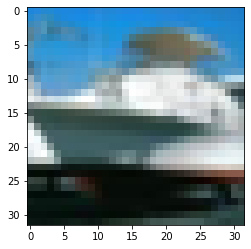

In [ ]:
# STEP 7: GET FEW PREDICTIONS ON TESTING IMAGES

import os
data_dir = './data/cifar10'
classes = os.listdir(data_dir + "/train")

def predict_image(img, model):
    img = img.unsqueeze(0).to(device)
    out = model(img)
    _, preds  = torch.max(out, dim=1)
    return train_ds.classes[preds[0].item()]

import matplotlib.pyplot as plt
img, label = test_ds[8367]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))